# Exam: Numerical Analysis for Machine Learning
## Ferbuary 7, 2023

### Exercise 1

Load the picture of Politecnico's facade `polimi_facade.jpg`. Pleas notice that the RGB object is a list of three matrices, each one corresponding to a different "channel" (i.e., red, green or blue)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

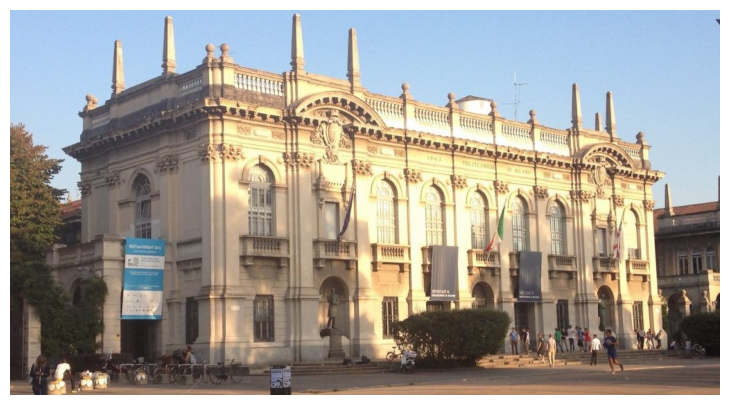

In [2]:
image_path = 'polimi_facade.jpg'
img = imread(image_path)

img_RGB = [np.array(img[:, :, i], dtype=np.float64)/255 for i in range(3)]

def plot_image(RGB, ax = None):
    if ax is None:
        _, ax = plt.subplots(1,1, figsize = (12,5))

    ax.imshow(np.clip(np.stack(RGB, axis = 2),0,1))
    plt.axis('off')


plot_image(img_RGB)




Now randomly replace $70\%$ of the pixels with random colors. 

In [4]:
damage_fraction = 0.7

np.random.seed(0)
mask_remove = np.random.choice(a=[True, False], size=(img.shape[0],img.shape[1]), p=[damage_fraction, 1-damage_fraction])
mask_keep = np.logical_not(mask_remove)

img_damaged_RGB = [img_RGB[i].copy() for i in range(3)]

for i in range(3):
    img_damaged_RGB[i][mask_remove] = np.random.rand(np.sum(mask_remove))

#### 1) Display the damaged image

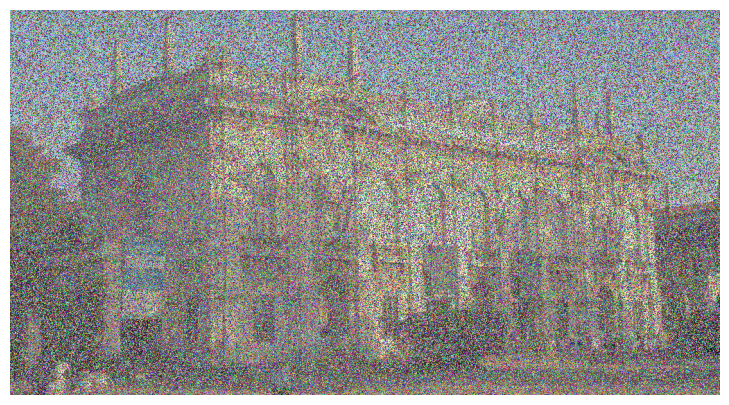

In [5]:
plot_image(img_damaged_RGB)

#### 2) Implement the singular value thresholding (SVT) algorithm to reconstruct the picture from `img_damaged_RGB`. 

(*Hint*: apply the algorithm independently to each channel)

In [8]:
def SVT_for_img(X0, tau, max_iter = 20, tol = 1e-6):

    R = X0[0].copy()
    G = X0[1].copy()
    B = X0[2].copy()

    channels = [R, G, B]

    for i in range(max_iter):
        cont = 0
        for j in range(3):
            U, S, V = np.linalg.svd(channels[j], full_matrices=False)
            S = np.maximum(S - tau, 0)
            new = U @ np.diag(S) @ V

            if np.linalg.norm(new - channels[j]) < tol:
                cont += 1
            channels[j] = new
        
        if cont == 3:
            break
    
    return channels

#### 3) Try to optimize by trial and error the threshold on the singular values. Run the algorithm for 20 iterations and plot the resulting image against the original and the damaged one

In [10]:
from tqdm import tqdm

Processing: 100%|██████████| 10/10 [05:12<00:00, 31.28s/it]


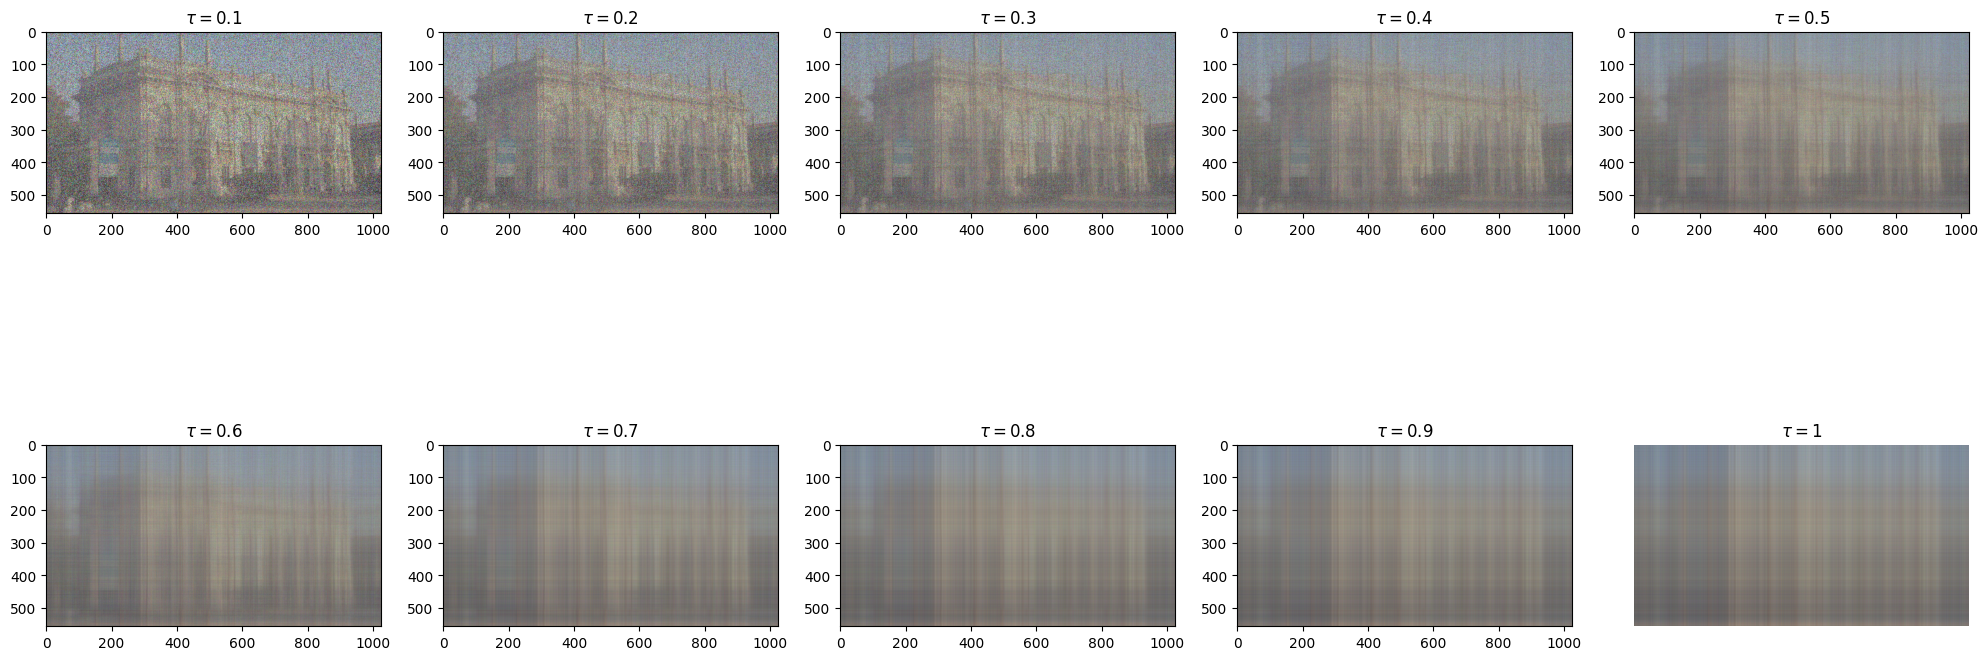

In [50]:
move = 0
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

_, ax = plt.subplots(2, 5, figsize = (20,10))
ax = ax.flatten()

for i in tqdm(range(len(taus)), desc = 'Processing'):
    img_reconstructed_RGB = SVT_for_img(img_damaged_RGB, taus[i] + move)
    plot_image(img_reconstructed_RGB, ax[i])
    ax[i].set_title(f'$\\tau = {taus[i]}$')

plt.tight_layout()
plt.show()

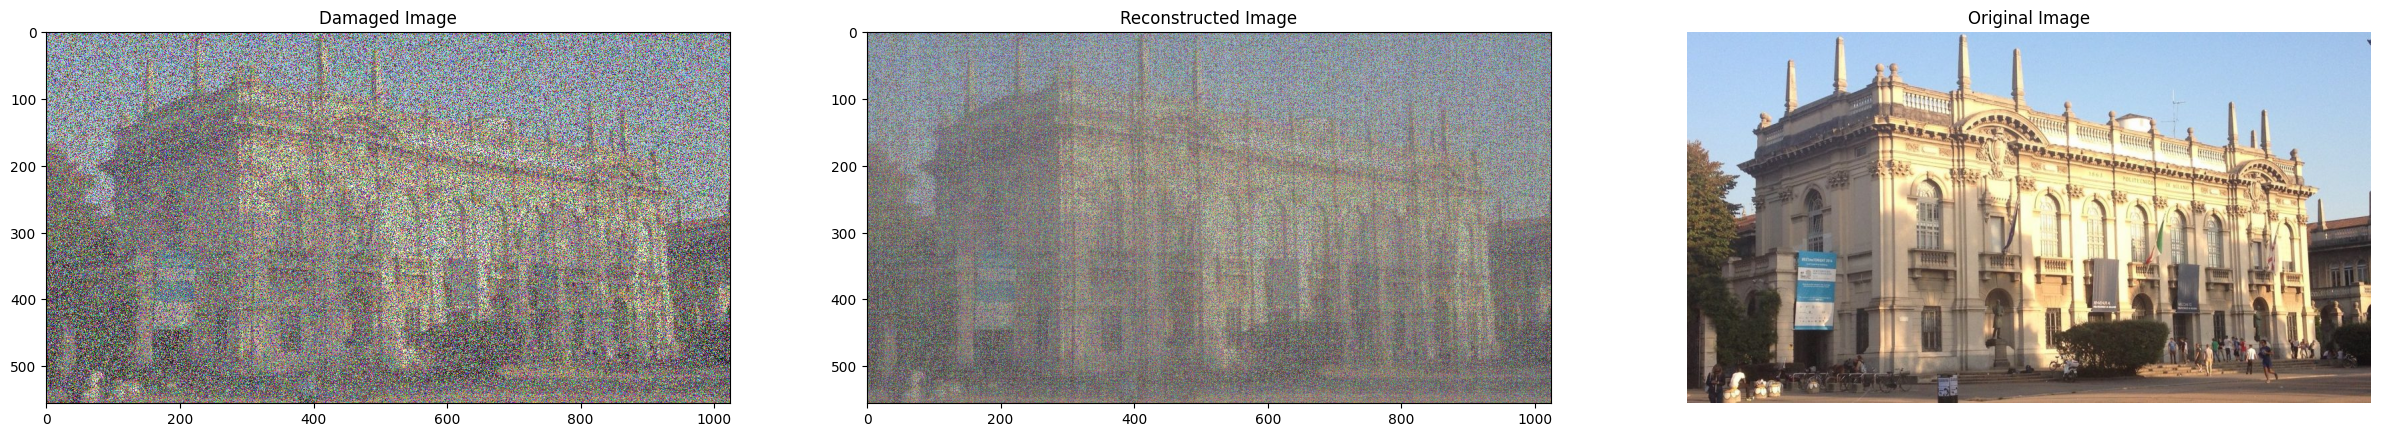

In [27]:
tau = 0.27

img_reconstructed_RGB = SVT_for_img(img_damaged_RGB, tau)

fig, ax = plt.subplots(1, 3, figsize = (30,10))

plot_image(img_damaged_RGB, ax[0])
ax[0].set_title('Damaged Image')

plot_image(img_reconstructed_RGB, ax[1])
ax[1].set_title('Reconstructed Image')

plot_image(img_RGB, ax[2])
ax[2].set_title('Original Image')


plt.show()

#### 4) Comment on the impact of the threshold on the results.

**Answer:**

We note that, the bigger the threshold, the smoother the reconstructed image becomes, but it will have less resolution over finer details.

In other words:

* Low threshold: the soft-thresholding operation only slightly reduces the singular values. In this case, most of the singular values (and hence, most of the information) are retained. This may result in insufficient denoising because noise components—often reflected in the smaller singular values—are not adequately suppressed. As a result, the denoised image might still appear noisy

* High threshold: aggressively shrinks the singular values, and many of them may be reduced to zero. This enforces a much lower rank approximation of the image. While this can be effective at removing noise (since noise typically appears in the less significant singular values), it can also lead to oversmoothing. Important details and textures in the image might be lost, resulting in a reconstructed image that appears overly simplified or “blurred.”

### Exercise 2

#### 1) Explain how a perceptron works and how to apply the gradient descent method to optimize the parameters of the perceptron

**Answer:**

A perceptron is a simple model for computational learning, the precursor of modern neural networks. It receives as input the data features, applies a linear transformation and then produces the classification output based on the sign of the resulting value.

Formally, a perceptron is defined as a function $f$, described as:

$$f(x) = \begin{cases} 1 & w^T x + b > 0 \\ 0 & \text{otherwise} \end{cases}$$

where $w, b$ are the parameters of the model. Note that we can determine the parameters of the perceptron by minimizing the classification error, given a labelled dataset. But to use iterative methods like the gradient descent, we need to modify the model to make it differentiable. So a slightly modified perceptron is as follows:

$$f(x) = \sigma(w^T x + b)$$

where $\sigma(x) = \frac{1}{1 + \exp(-x)}$$ is the sigmoid function. For binary classification problems, we use the crossentropy loss function defined as:

$$L(y, \hat{y}) = y \log(\hat{y}) + (1 - y) \log(1 - \hat{y})$$

Now, the gradient descent method works by updating the parameters as follows:

$$w^{(k)} = w^{(k-1)} - \eta \nabla_w L$$
$$b^{(k)} = b^{(k-1)} - \eta \nabla_b L$$

To calculate the gradients, we use the chain rule:

$$\nabla L_w = \frac{d L}{d \hat{y}} \cdot \frac{d\hat{y}}{d z} \cdot \nabla_w z$$ 
$$\nabla L_b = \frac{d L}{d \hat{y}} \cdot \frac{d\hat{y}}{d z} \cdot \nabla_b z$$

where $\hat{y} = \sigma(z)$ and $z = w^T + b$. Then, we have:

$$\frac{d L}{d \hat{y}} = \frac{\hat{y} - y}{\hat{y} (1 - \hat{y})}$$
$$\frac{d\hat{y}}{d z} = \hat{y}(1 - \hat{y})$$
$$\nabla_w z = x$$
$$\nabla_b z = 1$$

Then:
$$\nabla_w L = (\hat{y} - y) x$$
$$\nabla_b L = (\hat{y} - y)$$

We use these values to update the parameters on each iteration of the gradient descent.

#### 2) Now consider the following set of data:

<p align="center">
  <img src="dataset.png" alt="Alt text">
</p>

#### Construct a possible separating hyperplane by hand. Express the parameters of the hyperplane in terms of the three parameters of the perceptron.

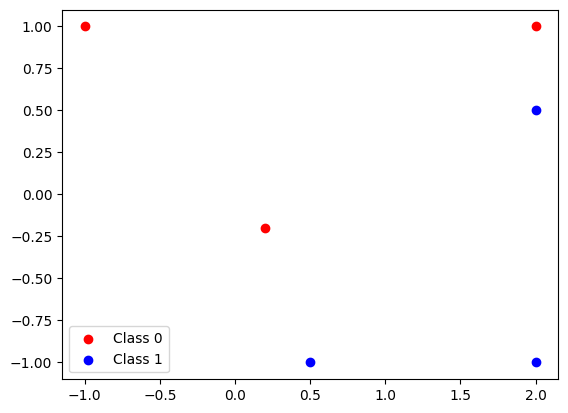

In [31]:
X = np.array([
    [2, -1],
    [-1, 1],
    [2, 0.5],
    [0.2, -0.2],
    [0.5, -1],
    [2, 1]
])

y = np.array([1, 0, 1, 0, 1, 0])


plt.scatter(X[y == 0, 0], X[y == 0, 1], c = 'r', label = 'Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c = 'b', label = 'Class 1')
plt.legend()

plt.show()

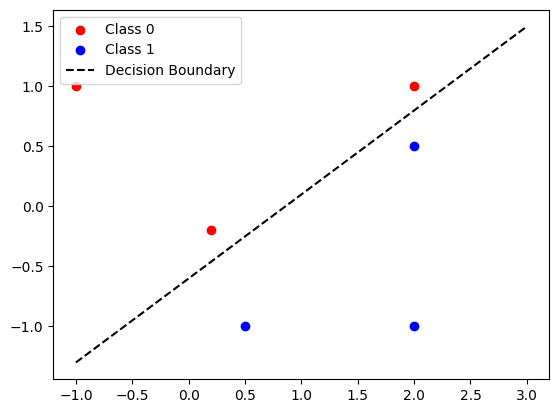

In [39]:
m = 0.7
c = -0.6

x = np.linspace(-1, 3, 100)
line = m * x + c

plt.scatter(X[y == 0, 0], X[y == 0, 1], c = 'r', label = 'Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c = 'b', label = 'Class 1')
plt.plot(x, line, 'k--', label = 'Decision Boundary')
plt.legend()

plt.show()

In [46]:
# Possible parameters for the decision boundary
w = np.array([-m, 1])
b = -c

print(f'w = {w}')
print(f'b = {b}')

w = [-0.7  1. ]
b = 0.6


#### 3) Implement and apply the perceptron algorithm using $w_0 = (1, 0)$ and $b_0 = 0$. Consider a learning rate $\eta = 2$. Draw on a figure the obtained hyperplane along with the data. 

w = [ 4.06491608 -5.65903456], b = -3.992321611439643


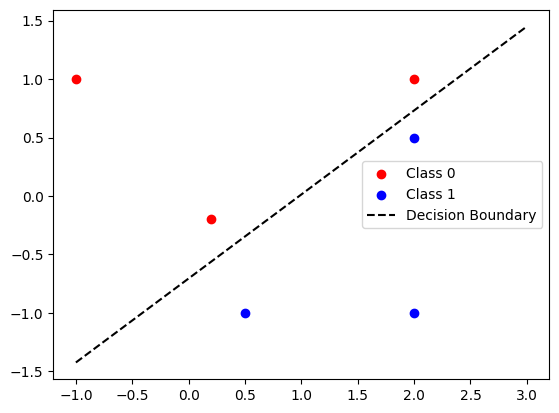

In [48]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))


def perceptron(X, w, b):
    return sigmoid(X @ w + b)


def train_perceptron(X, y, w0, b0, lr = 2, max_iter = 100):
    w = w0.copy()
    b = b0

    for i in range(max_iter):
        y_pred = perceptron(X, w, b)
        w -= lr * X.T @ (y_pred - y) / len(y)
        b -= lr * np.mean(y_pred - y)
    
    return w, b


w0 = np.array([1.0, 0.0])
b0 = 0

w, b = train_perceptron(X, y, w0, b0)

print(f'w = {w}, b = {b}')

x = np.linspace(-1, 3, 100)
line = -w[0]/w[1] * x - b/w[1]

plt.scatter(X[y == 0, 0], X[y == 0, 1], c = 'r', label = 'Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c = 'b', label = 'Class 1')

plt.plot(x, line, 'k--', label = 'Decision Boundary')
plt.legend()

plt.show()

#### 4) Apply again the algorithm with $\eta = 0.5$. Draw on a figure the obtained hyperplane along with the data.

w = [ 1.96581209 -3.02832509], b = -1.8083399359442545


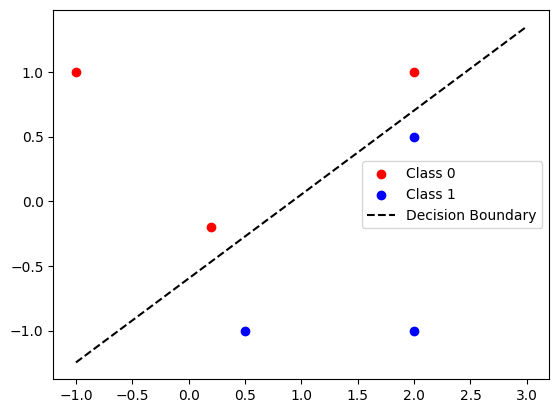

In [49]:
w, b = train_perceptron(X, y, w0, b0, lr = 0.5)

print(f'w = {w}, b = {b}')

x = np.linspace(-1, 3, 100)
line = -w[0]/w[1] * x - b/w[1]

plt.scatter(X[y == 0, 0], X[y == 0, 1], c = 'r', label = 'Class 0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c = 'b', label = 'Class 1')

plt.plot(x, line, 'k--', label = 'Decision Boundary')
plt.legend()

plt.show()

### Exercise 3

Suppose that the output $\hat{y}_k$ of a given unit in a neural network is given by the softmax function, i.e.:

$$\hat{y}_k = \frac{\exp(a_k)}{\sum_j \exp(a_j)}$$

#### 1) Show that the output of the softmax function does not change if you shift, in all components, the activations $a_j$ by some constant $c$.

**Answer:**

$$\tilde{y}_k = \frac{\exp(a_k + c)}{\sum_j \exp(a_j + c)} = \frac{\exp(c) \exp(a_k)}{\exp(c) \sum_j \exp(a_j)} = \frac{\exp(a_k)}{\sum_j \exp(a_j)} = \hat{y}_k$$

#### 2) Explain why the shift $c = - \max_j(a_j)$ can be useful.

**Answer:**

With the proposed shift, each coordinate of the vector $a$ becomes non-positive. This means that:

$$a_j \leq 0 \quad \forall j$$
$$\implies \exp(a_j) \leq 1 \quad \forall j$$

This, along with the fact that $\exp(x) > 0 \; \forall x$, avoids the explosion of the terms in the softmax function, that could lead to numerical errors. 